In [4]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch.utils.data
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
from convlstm import *

import glob
from torch.utils.data import Dataset, DataLoader

# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

import pickle
import numpy as np
import pandas as pd
import os

from ast import literal_eval
#from IPython.display import clear_output

from NN_helpers import *

import seaborn as sns
sns.set(style='whitegrid',font_scale=1.2)

In [3]:
data_train = hospitalDataset('train_new.csv')
data_test = hospitalDataset('test_new.csv')

In [6]:
net = Net()

LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss(reduction='none')  

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

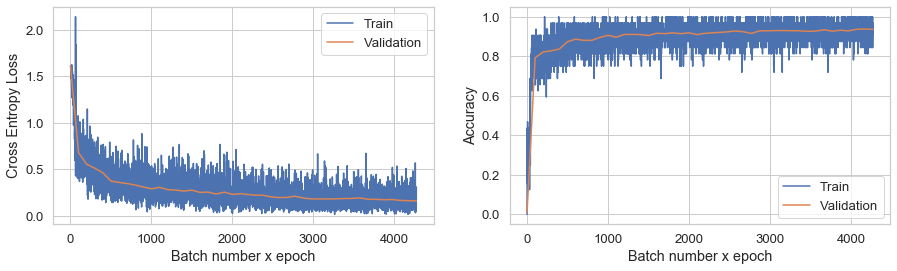

In [7]:
# Setup settings for training 
batch_size=32
max_iter = 199999
log_every = 100
eval_every = 100
num_epochs = 2



# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen_train = DataLoader(data_train, batch_size, shuffle=True, num_workers=0)
batch_gen_valid = DataLoader(data_test, batch_size, shuffle=True, num_workers=0)

# Train network
j=0
net.train()
for epoch in range(num_epochs):
    for i, batch_train in enumerate(batch_gen_train):
        j+=1
        if i % eval_every == 0:
            

            # Do the validaiton
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            with torch.no_grad(): 
                for batch_valid in batch_gen_valid:
                    num = len(batch_valid['target'])
                    output = net(get_input(batch_valid))
                    labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
                    val_losses += torch.sum(criterion(output['out'], labels_argmax))
                    val_accs += accuracy(output['out'], labels_argmax) * num
                    val_lengths += num

                # Divide by the total accumulated batch sizes
                val_losses /= val_lengths
                val_accs /= val_lengths
                valid_loss.append(get_numpy(val_losses))
                valid_accs.append(get_numpy(val_accs))
                valid_iter.append(j)
        #         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
                net.train()

        # Train network
        output = net(get_input(batch_train))
        labels_argmax = torch.max(get_labels(batch_train), 1)[1]

        batch_loss = torch.mean(criterion(output['out'], labels_argmax))

        train_iter.append(j)
        train_loss.append(float(get_numpy(batch_loss)))
        train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Log i figure
        if i % log_every == 0:
            fig = plt.figure(figsize=(15,4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='Train')
            plt.plot(valid_iter, valid_loss, label='Validation')
            plt.xlabel('Batch number x epoch')
            plt.ylabel('Cross Entropy Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_iter, train_accs, label='Train')
            plt.plot(valid_iter, valid_accs, label='Validation')
            plt.xlabel('Batch number x epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()
            clear_output(wait=True)
            #print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
            
        if max_iter == i:
            break

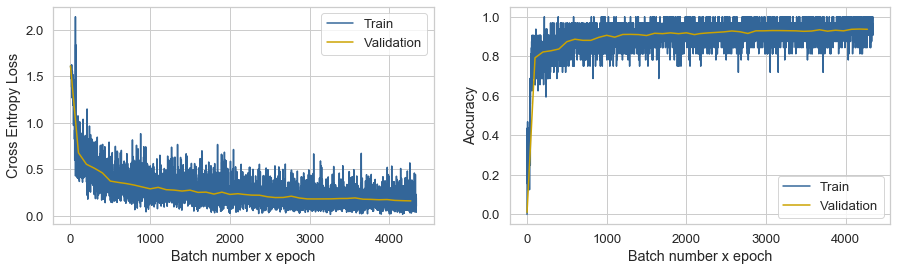

In [44]:
fig = plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter, train_loss, label='Train', color='#336699')
plt.plot(valid_iter, valid_loss, label='Validation', color='#CCA300')
plt.xlabel('Batch number x epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter, train_accs, label='Train', color='#336699')
plt.plot(valid_iter, valid_accs, label='Validation', color='#CCA300')
plt.xlabel('Batch number x epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()